In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Obtain the imdb review dataset from tensorflow datasets
dataset = tfds.load('imdb_reviews', as_supervised=True)

In [4]:
# Seperate test and train datasets
train_dataset, test_dataset = dataset['train'], dataset ['test']

In [5]:
#Split the test and train data into batches of 32
#and shuffling the training set
batch_size = 32
train_dataset = train_dataset.shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [6]:
example, label = next(iter(train_dataset))
print('Text:\n', example.numpy()[0])
print('\nLabel: ', label.numpy()[0])

Text:
 b'Generally speaking, the plot was much better than I was expecting. The laugh track was a bit annoying at times and did tend to get in the way; however, there were enough real chuckles in this episode to make up for it. My biggest surprise was finding some of the best lines and situations were not shown in the trailers. Spade, in particular, was not presented in the best light in the earlier promotions, but his character comes across quite well in the pilot. There is is enough eye-candy to please almost anyone and all the regular characters seem up to the task ahead of them. Now, if the writers can just live up to what they have begun.'

Label:  1


In [7]:
encoder = tf.keras.layers.TextVectorization(max_tokens=10000)
encoder.adapt(train_dataset.map(lambda text,_: text))

In [8]:
# Extracting the vocabulary from the TextVectorization layer.
vocabulary = np.array(encoder.get_vocabulary())

In [9]:
# Encoding a test example and decoding it back.
original_text = example.numpy()[0]
encoded_text = encoder(original_text).numpy()
decoded_text = ' '.join(vocabulary[encoded_text])

In [10]:
print('original: ', original_text)
print('encoded: ', encoded_text)
print('decoded:', decoded_text)

original:  b'Generally speaking, the plot was much better than I was expecting. The laugh track was a bit annoying at times and did tend to get in the way; however, there were enough real chuckles in this episode to make up for it. My biggest surprise was finding some of the best lines and situations were not shown in the trailers. Spade, in particular, was not presented in the best light in the earlier promotions, but his character comes across quite well in the pilot. There is is enough eye-candy to please almost anyone and all the regular characters seem up to the task ahead of them. Now, if the writers can just live up to what they have begun.'
encoded:  [1181 1407    2  114   14   73  125   71   10   14  982    2  475 1390
   14    4  221  613   31  211    3  117 2250    6   76    8    2   97
  186   48   66  190  146 7832    8   11  383    6   94   58   16    9
   56 1081  859   14 1462   47    5    2  115  406    3 1160   66   22
  595    8    2 4159 8405    8  817   14   22 131

In [11]:
# Print shapes of datasets
print(f'Train dataset shape: {train_dataset.element_spec}')
print(f'Test dataset shape: {test_dataset.element_spec}')

Train dataset shape: (TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))
Test dataset shape: (TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))


In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,), dtype=tf.string),
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [13]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 64)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, None, 128)      │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 751,489 (2.87 MB)

 Trainable params: 751,489 (2.87 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history = model.fit(train_dataset, epochs=5, validation_data=test_dataset)

Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 523s 660ms/step - accuracy: 0.6992 - loss: 0.5302 - val_accuracy: 0.8627 - val_loss: 0.3122
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 563s 720ms/step - accuracy: 0.8864 - loss: 0.2736 - val_accuracy: 0.8460 - val_loss: 0.3440
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 536s 686ms/step - accuracy: 0.9275 - loss: 0.1850 - val_accuracy: 0.8647 - val_loss: 0.3404
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 523s 669ms/step - accuracy: 0.9590 - loss: 0.1134 - val_accuracy: 0.8675 - val_loss: 0.3832
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 526s 673ms/step - accuracy: 0.9763 - loss: 0.0670 - val_accuracy: 0.8564 - val_loss: 0.4526


In [16]:
import pickle

In [17]:
import pickle

with open('history.pkl', 'wb') as file:
    pickle.dump(history.history, file)  # Save only the train/validation accuracy/loss values

In [18]:
# ----------- Retrive Data -----------

# with open('history.pkl', 'rb') as file:
#     saved_history = pickle.load(file)

# Access training and validation accuracy/loss
# acc = saved_history['accuracy']
# val_acc = saved_history['val_accuracy']

In [19]:
history_dict = history.history

In [20]:
# Seperating validation and training accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

In [21]:
# Seperating validation and training loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

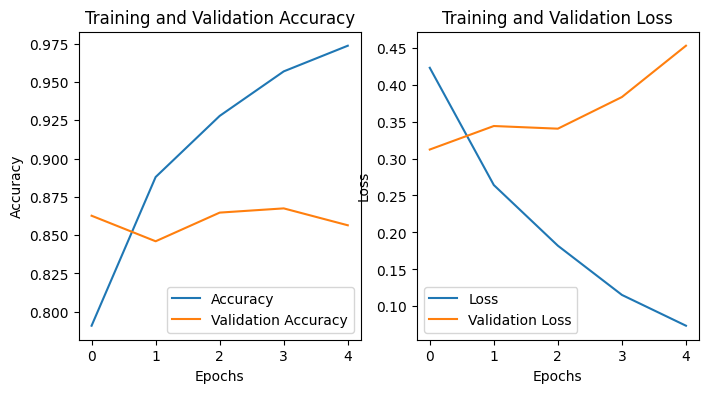

In [22]:
plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Validation Accuracy'])
plt.subplot(1, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss', 'Validation Loss'])
plt.show()

In [23]:
sample_text = (
    '''The movie by Meher Ramesh was so good and the animation are so nice in Adipurush.
    I would recommend my friends to watch it.'''
)

In [24]:
# Convert the input to a TensorFlow constant
sample_text_tensor = tf.constant([sample_text])

In [25]:
# Now pass the input to the model for prediction
predictions = model.predict(sample_text_tensor)
print(*predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step
3.627267


In [26]:
# Print the label based on the prediction
print(sample_text)
if predictions[0] > 0:
    print('The review is positive')
else:
    print('The review is negative')

The movie by Meher Ramesh was so good and the animation are so nice in Adipurush.
    I would recommend my friends to watch it.
The review is positive
